# Correlational analysis

This notebook contains correlational analyses of the recommendation list inputs and outputs, for comparison purposes and also to analyze the control bias.

## Setup

In [1]:
import pickle

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import logit, expit

In [3]:
with open('data/profile-data.pkl', 'rb') as f:
    profiles = pickle.load(f)
profiles.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 25000 entries, ('AZ', 529) to ('GR-I', 875516)
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   count       25000 non-null  int32  
 1   linked      25000 non-null  int32  
 2   ambiguous   25000 non-null  int32  
 3   male        25000 non-null  int32  
 4   female      25000 non-null  int32  
 5   dcknown     25000 non-null  int32  
 6   dcyes       25000 non-null  int32  
 7   PropDC      25000 non-null  float64
 8   Known       25000 non-null  int32  
 9   PropFemale  25000 non-null  float64
 10  PropKnown   25000 non-null  float64
dtypes: float64(3), int32(8)
memory usage: 2.2+ MB


In [4]:
with open('data/rec-data.pkl', 'rb') as f:
    recs = pickle.load(f)
recs.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 94146 entries, ('AZ', 'als', 529) to ('GR-I', 'wrls', 875516)
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ambiguous   94146 non-null  int64  
 1   female      94146 non-null  int64  
 2   male        94146 non-null  int64  
 3   unknown     94146 non-null  int64  
 4   Total       94146 non-null  int64  
 5   Known       94146 non-null  int64  
 6   PropKnown   94146 non-null  float64
 7   PropFemale  93926 non-null  float64
 8   dcknown     94146 non-null  int64  
 9   dcyes       94146 non-null  int32  
 10  PropDC      94115 non-null  float64
dtypes: float64(3), int32(1), int64(7)
memory usage: 8.7+ MB


Helpers from RecModel Analysis:

In [5]:
def select_implicit(data, reset=True):
    if reset:
        data = data.reset_index()
    implicit = data['Set'].str.endswith('-I')
    if 'Algorithm' in data.columns:
        implicit |= data['Algorithm'].str.endswith('-imp')
    else:
        implicit |= data['Set'] == 'AZ'
    data = data.loc[implicit].assign(Set=data['Set'].str.replace('-I', ''))
    if 'Algorithm' in data.columns:
        data['Algorithm'] = data['Algorithm'].str.replace('-imp', '').str.replace('wrls', 'als')
    return data

In [6]:
def select_explicit(data, reset=True):
    if reset:
        data = data.reset_index()
    implicit = data['Set'].str.endswith('-I') 
    if 'Algorithm' in data.columns:
        implicit |= data['Algorithm'].str.endswith('-imp')
    data = data[~implicit].assign(Set=data['Set'].str.replace('-E', ''))
    return data

## Observed Profile Parameters

What do proportions look like, for both female authors and dummy codes?

In [7]:
profiles.groupby('Set')[['PropFemale', 'PropDC']].agg(['mean', 'std']).T

Set                    AZ      BX-E      BX-I      GR-E      GR-I
PropFemale mean  0.414445  0.418886  0.407030  0.446998  0.450201
           std   0.329436  0.267354  0.254304  0.276480  0.269127
PropDC     mean  0.498460  0.494217  0.499506  0.494855  0.497091
           std   0.160820  0.151552  0.144868  0.082914  0.069235

What does the distribution look like?

In [8]:
props = pd.melt(profiles.reset_index(), ['Set', 'user'], ['PropFemale', 'PropDC'])
props.head()

,Set,user,variable,value
0,AZ,529,PropFemale,0.800000
1,AZ,1723,PropFemale,0.285714
2,AZ,1810,PropFemale,0.000000
3,AZ,2781,PropFemale,0.166667
4,AZ,2863,PropFemale,0.000000


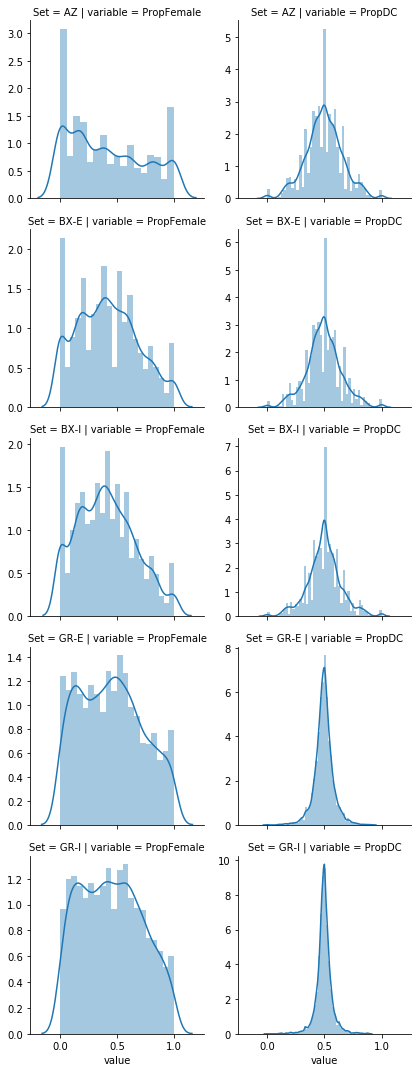

In [9]:
grid = sns.FacetGrid(props, col='variable', row='Set', sharey=False)
grid.map(sns.distplot, 'value')

## Rec list distributions

In [10]:
rec_props = pd.melt(recs.reset_index(), ['Set', 'Algorithm', 'user'], ['PropFemale', 'PropDC'])
rec_props.head()

,Set,Algorithm,user,variable,value
0,AZ,als,529,PropFemale,0.296296
1,AZ,als,1723,PropFemale,0.571429
2,AZ,als,1810,PropFemale,0.400000
3,AZ,als,2781,PropFemale,0.320000
4,AZ,als,2863,PropFemale,0.137931


Implicit algorithm distributions:

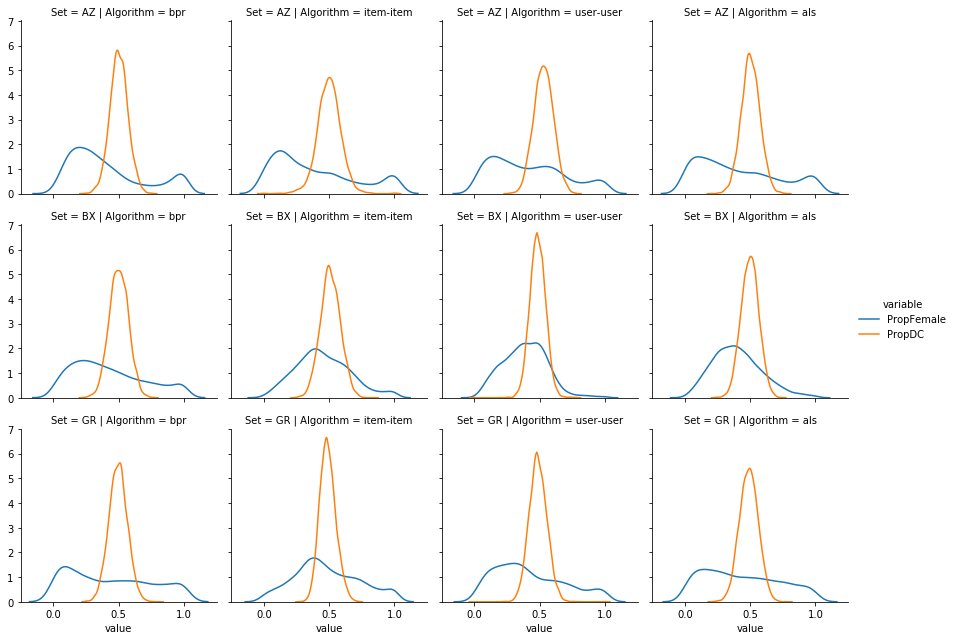

In [11]:
grid = sns.FacetGrid(select_implicit(rec_props), row='Set', col='Algorithm', hue='variable')
grid.map(sns.kdeplot, 'value')
grid.add_legend()

Explicit algorithm distributions:

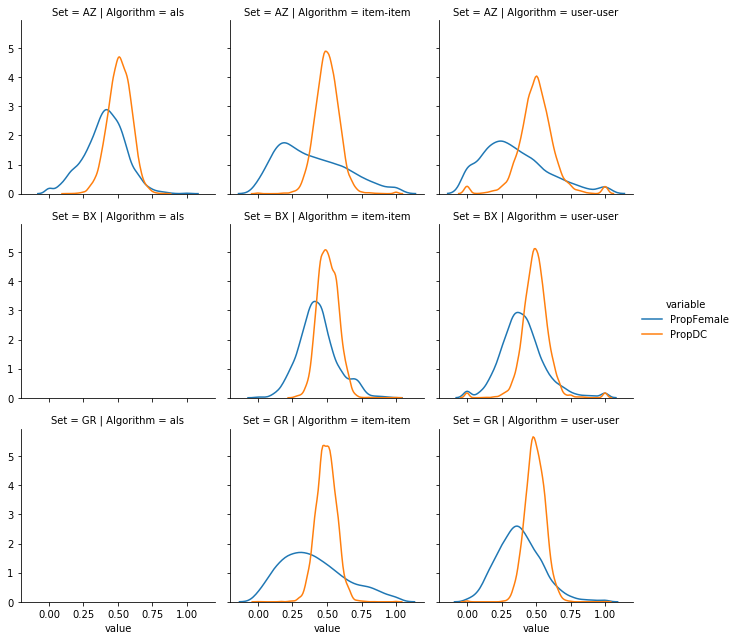

In [12]:
grid = sns.FacetGrid(select_explicit(rec_props), row='Set', col='Algorithm', hue='variable')
grid.map(sns.kdeplot, 'value')
grid.add_legend()

## Let's look at correlations!

### Implicit feedback mode

First, extract the recommendation data:

In [13]:
imp_rd = select_implicit(recs)
imp_rd = imp_rd.melt(['Set', 'user', 'Algorithm'], ['PropFemale', 'PropDC'], value_name='recs')
imp_rd.set_index(['Set', 'user', 'Algorithm', 'variable'], inplace=True)
imp_rd.sort_index(inplace=True)
imp_rd

recs
Set user   Algorithm variable            
AZ  529    als       PropDC      0.489796
                     PropFemale  0.800000
           bpr       PropDC      0.466667
                     PropFemale  0.464286
           item-item PropDC      0.600000
...                                   ...
GR  875516 bpr       PropFemale  0.093023
           item-item PropDC      0.400000
                     PropFemale  0.361111
           user-user PropDC      0.520000
                     PropFemale  0.083333

[119950 rows x 1 columns]

Now the profile data:

In [14]:
imp_prof = profiles.reset_index()
imp_prof = imp_prof[~imp_prof['Set'].str.endswith('-E')]
imp_prof['Set'] = imp_prof['Set'].str.replace('-I$', '')
imp_prof = imp_prof.melt(['Set', 'user'], ['PropFemale', 'PropDC'], value_name='profile')
imp_prof.set_index(['Set', 'user', 'variable'], inplace=True)
imp_prof.sort_index(inplace=True)
imp_prof

profile
Set user   variable            
AZ  529    PropDC      0.375000
           PropFemale  0.800000
    1723   PropDC      0.560000
           PropFemale  0.285714
    1810   PropDC      0.125000
...                         ...
GR  875408 PropFemale  0.284211
    875441 PropDC      0.485714
           PropFemale  0.821990
    875516 PropDC      0.523148
           PropFemale  0.115044

[30000 rows x 1 columns]

And now merge it:

In [15]:
joint = imp_prof.join(imp_rd)
joint

profile      recs
Set user   variable   Algorithm                    
AZ  529    PropDC     als        0.375000  0.489796
                      bpr        0.375000  0.466667
                      item-item  0.375000  0.600000
                      user-user  0.375000  0.489796
           PropFemale als        0.800000  0.800000
...                                   ...       ...
GR  875516 PropDC     user-user  0.523148  0.520000
           PropFemale als        0.115044  0.040000
                      bpr        0.115044  0.093023
                      item-item  0.115044  0.361111
                      user-user  0.115044  0.083333

[119950 rows x 2 columns]

And compute profile-rec correlations:

In [16]:
joint.groupby(['Set', 'Algorithm', 'variable']).apply(lambda df: df['profile'].corr(df['recs'])).unstack()

variable         PropDC  PropFemale
Set Algorithm                      
AZ  als       -0.024951    0.822392
    bpr       -0.021407    0.630675
    item-item  0.012452    0.705908
    user-user  0.005395    0.803753
BX  als       -0.002632    0.735219
    bpr       -0.001114    0.774075
    item-item -0.023173    0.560200
    user-user -0.045251    0.595326
GR  als       -0.008759    0.902928
    bpr        0.001138    0.892903
    item-item -0.064934    0.773523
    user-user -0.062454    0.813079

### Explicit-feedback mode

First, extract the recommendation data:

In [17]:
exp_rd = select_explicit(recs)
exp_rd = exp_rd.melt(['Set', 'user', 'Algorithm'], ['PropFemale', 'PropDC'], value_name='recs')
exp_rd.set_index(['Set', 'user', 'Algorithm', 'variable'], inplace=True)
exp_rd.sort_index(inplace=True)
exp_rd

recs
Set user   Algorithm variable            
AZ  529    als       PropDC      0.522727
                     PropFemale  0.296296
           item-item PropDC      0.512195
                     PropFemale  0.684211
           user-user PropDC      0.613636
...                                   ...
GR  875920 user-user PropFemale  0.192308
    875927 item-item PropDC      0.560000
                     PropFemale  0.500000
           user-user PropDC      0.540000
                     PropFemale  0.304348

[68342 rows x 1 columns]

Now the profile data:

In [18]:
exp_prof = profiles.reset_index()
exp_prof = exp_prof[~exp_prof['Set'].str.endswith('-I')]
exp_prof['Set'] = exp_prof['Set'].str.replace('-E$', '')
exp_prof = exp_prof.melt(['Set', 'user'], ['PropFemale', 'PropDC'], value_name='profile')
exp_prof.set_index(['Set', 'user', 'variable'], inplace=True)
exp_prof.sort_index(inplace=True)
exp_prof

profile
Set user   variable            
AZ  529    PropDC      0.375000
           PropFemale  0.800000
    1723   PropDC      0.560000
           PropFemale  0.285714
    1810   PropDC      0.125000
...                         ...
GR  875863 PropFemale  0.964602
    875920 PropDC      0.451613
           PropFemale  0.133333
    875927 PropDC      0.608696
           PropFemale  0.588235

[30000 rows x 1 columns]

And now merge it:

In [19]:
joint = exp_prof.join(exp_rd)
joint

profile      recs
Set user   variable   Algorithm                    
AZ  529    PropDC     als        0.375000  0.522727
                      item-item  0.375000  0.512195
                      user-user  0.375000  0.613636
           PropFemale als        0.800000  0.296296
                      item-item  0.800000  0.684211
...                                   ...       ...
GR  875920 PropFemale user-user  0.133333  0.192308
    875927 PropDC     item-item  0.608696  0.560000
                      user-user  0.608696  0.540000
           PropFemale item-item  0.588235  0.500000
                      user-user  0.588235  0.304348

[68364 rows x 2 columns]

And compute profile-rec correlations:

In [20]:
joint.groupby(['Set', 'Algorithm', 'variable']).apply(lambda df: df['profile'].corr(df['recs'])).unstack()

variable         PropDC  PropFemale
Set Algorithm                      
AZ  als       -0.030883    0.220817
    item-item  0.011453    0.619091
    user-user -0.026146    0.535963
BX  item-item -0.034358    0.296007
    user-user  0.001537    0.379183
GR  item-item -0.035269    0.622149
    user-user  0.006073    0.487080